#**Problem Statement**

Build an AI model that can classify SMS messages as spam or
legitimate. Use techniques like TF-IDF with
classifiers like Naive Bayes, Logistic Regression, or Support Vector
Machines to identify spam messages

#**Importing Necessary Libraries**

In [83]:
# Importing necessary libraries
import pandas as pd  # Importing pandas for data manipulation
import requests  # Importing requests to fetch data from URLs
import re  # Importing re for regular expressions
from sklearn.feature_extraction.text import TfidfVectorizer  # Importing TfidfVectorizer for text feature extraction
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  # Importing sklearn utilities for model training and evaluation
from sklearn.naive_bayes import MultinomialNB  # Importing Multinomial Naive Bayes classifier
from sklearn.linear_model import LogisticRegression  # Importing Logistic Regression classifier
from sklearn.svm import SVC  # Importing Support Vector Machine classifier
from sklearn.metrics import (  # Importing metrics for model evaluation
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
import matplotlib.pyplot as plt  # Importing matplotlib for plotting
import seaborn as sns  # Importing seaborn for enhanced plotting capabilities
import numpy as np  # Importing numpy for numerical computations
from wordcloud import WordCloud  # Importing WordCloud for visualizing word clouds
import joblib  # Importing joblib for saving and loading models


#**Loading Dataset**

**Loading Data from GitHub**

In [84]:
# lading the dataset from the github by URL
dataset_url = 'https://raw.githubusercontent.com/AbhishekYadav-01/Encryptix/main/SPAM_SMS_DETECTION/spam.csv'

# Fetch the dataset as raw text from the URL
response_data = requests.get(dataset_url)
data_raw_text = response_data.text

# Printing the first 600 characters of the dataset to inspect its structure (first 6 lines of the dataset)
print(data_raw_text[:600])


ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...			
ham	Ok lar... Joking wif u oni...			
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's			
ham	U dun say so early hor... U c already then say...			
ham	Nah I don't think he goes to usf, he lives around here though			
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv	


**Parse the Dataset**

In [85]:
# Defiing the pattern to split the raw text based on 'ham' and 'spam' labels
pattern_split = r'(\bham\b|\bspam\b)'

# Splitting the raw text data using the defined pattern and remove the first empty element
message_parts = re.split(pattern_split, data_raw_text)[1:]

# Extracting labels from even-indexed elements and messages from odd-indexed elements
labels = message_parts[0::2]
messages = message_parts[1::2]

# Creating a DataFrame with 'label' and 'message' columns from extracted parts
data_processed = pd.DataFrame({'label': labels, 'message': messages})

# Removing leading and trailing whitespace characters from the 'message' column
data_processed['message'] = data_processed['message'].str.strip()

# Printing the first few rows of the processed data to verify the structure
print(data_processed.head())


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


**Data Cleaning**

In [86]:
# Droping rows with any missing values from the processed data
data_processed.dropna(inplace=True)

# Ensuring there are no NaN values remaining in the processed data
print(data_processed.isnull().sum())

# Mapping 'ham' to 0 and 'spam' to 1 in the 'label' column
data_processed['label'] = data_processed['label'].map({'ham': 0, 'spam': 1})

# checking that there are no NaN values in the 'label' column after mapping
data_processed.dropna(inplace=True)
print(data_processed.isnull().sum())

# Removing rows with empty messages from the processed data
data_processed = data_processed[data_processed['message'].str.strip() != '']

# Printing the count of NaN values after cleaning
print(data_processed.isnull().sum())

# Printing the total number of samples after cleaning
print(f"Number of samples: {len(data_processed)}")


label      0
message    0
dtype: int64
label      0
message    0
dtype: int64
label      0
message    0
dtype: int64
Number of samples: 5576


**Data Distribution**

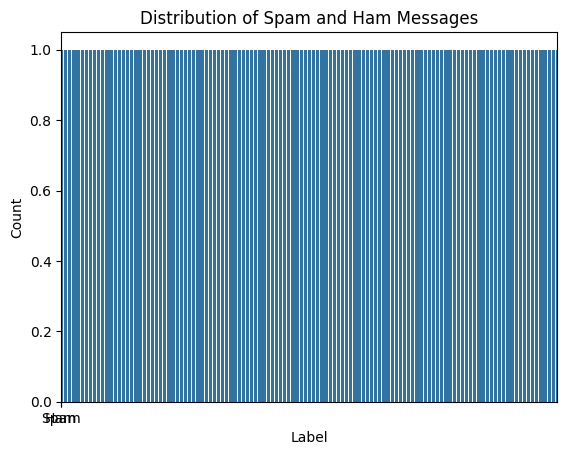

label
0    4829
1     747
Name: count, dtype: int64


In [87]:
# Visualize the distribution of spam and ham messages using a count plot
sns.countplot(data_processed['label'])
plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

# Print the count of spam (label=1) and ham (label=0) messages
print(data_processed['label'].value_counts())


**Message Length Distribution**

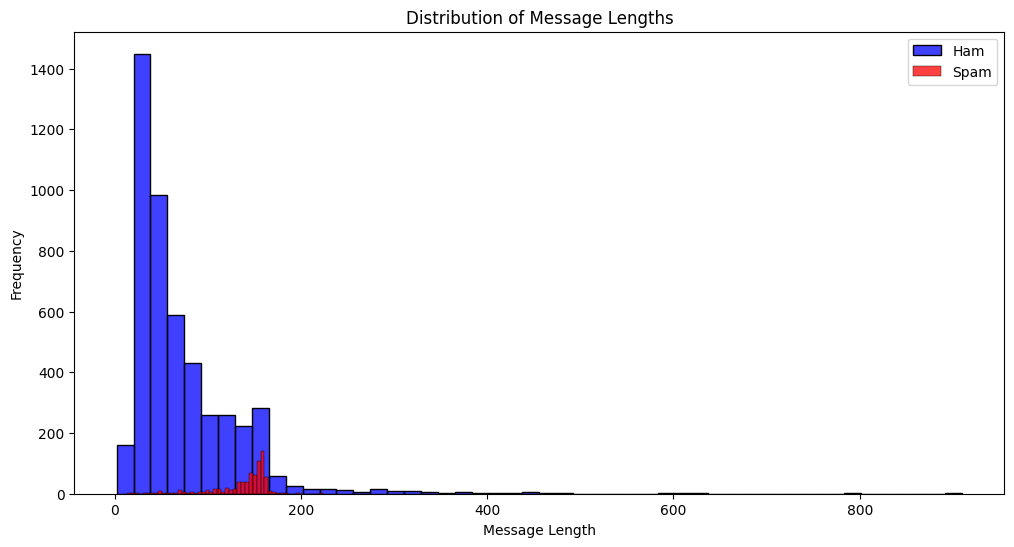

In [88]:
# Calculate message lengths and add as a new column in the DataFrame
data_processed['message_length'] = data_processed['message'].apply(len)

# Plot the distribution of message lengths for ham (label=0) and spam (label=1) messages
plt.figure(figsize=(12, 6))  # Set the figure size for the plot
# Plot histogram for ham messages (label=0) with blue color and label
sns.histplot(data_processed[data_processed['label'] == 0]['message_length'], bins=50, color='blue', label='Ham')
# Plot histogram for spam messages (label=1) with red color and label
sns.histplot(data_processed[data_processed['label'] == 1]['message_length'], bins=50, color='red', label='Spam')
plt.title('Distribution of Message Lengths')  # Set the title of the plot
plt.xlabel('Message Length')  # Set the x-axis label
plt.ylabel('Frequency')  # Set the y-axis label
plt.legend()  # Show the legend for different message types (ham and spam)
plt.show()  # Display the plot


**Common Words in Messages**

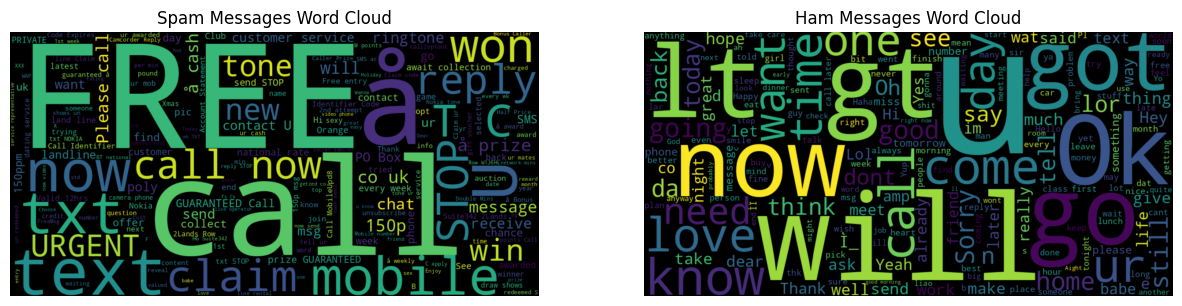

In [89]:

# Combining all spam and ham messages into single strings
spam_messages_combined = " ".join(data_processed[data_processed['label'] == 1]['message'])
ham_messages_combined = " ".join(data_processed[data_processed['label'] == 0]['message'])

# Generating word clouds for spam and ham messages
# WordCloud parameters: width=1200 pixels, height=600 pixels, black background
spam_wordcloud = WordCloud(width=1200, height=600, background_color='black').generate(spam_messages_combined)
ham_wordcloud = WordCloud(width=1200, height=600, background_color='black').generate(ham_messages_combined)

# Plot the word clouds side by side
plt.figure(figsize=(15, 8))  # Set the overall figure size

# Subplot 1: Spam Word Cloud
plt.subplot(1, 2, 1)  # Create subplot 1 in a 1x2 grid
plt.imshow(spam_wordcloud, interpolation='bilinear')  # Display the word cloud with bilinear interpolation
plt.title('Spam Messages Word Cloud')  # Set the title for subplot 1
plt.axis('off')  # Turn off axis labels and ticks

# Subplot 2: Ham Word Cloud
plt.subplot(1, 2, 2)  # Create subplot 2 in a 1x2 grid
plt.imshow(ham_wordcloud, interpolation='bilinear')  # Display the word cloud with bilinear interpolation
plt.title('Ham Messages Word Cloud')  # Set the title for subplot 2
plt.axis('off')  # Turn off axis labels and ticks

plt.show()  # Display the entire plot


#**Feature Extraction using TF-IDF**

In [90]:

# Initialize TF-IDF Vectorizer with adjusted parameters:
# - stop_words='english': Remove common English words (like 'the', 'is', 'and')
# - max_df=0.95: Ignore terms that appear in more than 95% of the documents
# - min_df=2: Ignore terms that appear in fewer than 2 documents
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

# Transform the messages into TF-IDF features
X_features = tfidf_vectorizer.fit_transform(data_processed['message'])

# Extract labels for classification
y_labels = data_processed['label']


#**Split Train and Evaluate Models**

**Split the Data into Training and Testing Sets**

In [91]:

# Splitting the TF-IDF features and labels into training and testing sets
X_train_tfidf, X_test_tfidf, y_train_labels, y_test_labels = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)


**Train and Evaluate Models**

In [92]:
# Initializing the classifiers
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM Linear Kernel": SVC(kernel='linear'),
    "SVM Polynomial Kernel": SVC(kernel='poly', degree=3),
    "SVM RBF Kernel": SVC(kernel='rbf')
}

# Training and evaluating each model
for model_name, classifier in models.items():
    # Train the model using TF-IDF transformed training data
    classifier.fit(X_train_tfidf, y_train_labels)

    # Predict on the test set
    y_pred_labels = classifier.predict(X_test_tfidf)

    # Print actual vs predicted values for the current model
    print(f"Model: {model_name}")
    print("Actual vs Predicted:")
    results = pd.DataFrame({'Actual': y_test_labels, 'Predicted': y_pred_labels})
    print(results)
    print()


Model: Naive Bayes
Actual vs Predicted:
      Actual  Predicted
3690       0          0
3527       0          0
724        0          0
3370       0          0
468        0          0
...      ...        ...
4864       0          1
3227       0          0
3796       0          0
2879       0          0
1350       0          0

[1116 rows x 2 columns]

Model: Logistic Regression
Actual vs Predicted:
      Actual  Predicted
3690       0          0
3527       0          0
724        0          0
3370       0          0
468        0          0
...      ...        ...
4864       0          0
3227       0          0
3796       0          0
2879       0          0
1350       0          0

[1116 rows x 2 columns]

Model: SVM Linear Kernel
Actual vs Predicted:
      Actual  Predicted
3690       0          0
3527       0          0
724        0          0
3370       0          0
468        0          0
...      ...        ...
4864       0          0
3227       0          0
3796       0          

In [93]:
# Evaluate each model
for model_name, classifier in models.items():
    # Train the model using TF-IDF transformed training data
    classifier.fit(X_train_tfidf, y_train_labels)

    # Predict on the test set
    y_pred_labels = classifier.predict(X_test_tfidf)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    precision = precision_score(y_test_labels, y_pred_labels)
    recall = recall_score(y_test_labels, y_pred_labels)
    f1 = f1_score(y_test_labels, y_pred_labels)

    # Print evaluation results for the current model
    print(f"{model_name} Model")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print()


Naive Bayes Model
Accuracy: 0.98
Precision: 0.99
Recall: 0.86
F1 Score: 0.92

Logistic Regression Model
Accuracy: 0.95
Precision: 0.98
Recall: 0.68
F1 Score: 0.80

SVM Linear Kernel Model
Accuracy: 0.98
Precision: 0.96
Recall: 0.86
F1 Score: 0.91

SVM Polynomial Kernel Model
Accuracy: 0.94
Precision: 1.00
Recall: 0.58
F1 Score: 0.73

SVM RBF Kernel Model
Accuracy: 0.98
Precision: 1.00
Recall: 0.86
F1 Score: 0.92



#**Hyperparameter Tuning**

**Hyperparameter Tuning for Logistic Regression**


In [94]:

# Defining parameter grid for Logistic Regression
param_grid_logreg = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Initialize GridSearchCV for Logistic Regression
grid_search_logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logreg, cv=5, scoring='f1')

# Performing grid search on training data
grid_search_logreg.fit(X_train_tfidf, y_train_labels)

# Best parameters and score
best_params_logreg = grid_search_logreg.best_params_
best_score_logreg = grid_search_logreg.best_score_

print(f"Best parameters for Logistic Regression: {best_params_logreg}")
print(f"Best F1 Score for Logistic Regression: {best_score_logreg:.2f}")




Best parameters for Logistic Regression: {'C': 100, 'solver': 'saga'}
Best F1 Score for Logistic Regression: 0.93


In [95]:
# Train and evaluate the best Logistic Regression model
best_logreg_model = grid_search_logreg.best_estimator_
y_pred_best_logreg = best_logreg_model.predict(X_test_tfidf)

accuracy_best_logreg = accuracy_score(y_test_labels, y_pred_best_logreg)
precision_best_logreg = precision_score(y_test_labels, y_pred_best_logreg)
recall_best_logreg = recall_score(y_test_labels, y_pred_best_logreg)
f1_best_logreg = f1_score(y_test_labels, y_pred_best_logreg)

print(f"Best Logistic Regression Model we got is ")
print(f"Accuracy: {accuracy_best_logreg:.2f}")
print(f"Precision: {precision_best_logreg:.2f}")
print(f"Recall: {recall_best_logreg:.2f}")
print(f"F1 Score: {f1_best_logreg:.2f}")

Best Logistic Regression Model we got is 
Accuracy: 0.98
Precision: 0.99
Recall: 0.90
F1 Score: 0.94


#**Advanced Model Evaluation**

**Confusion Matrix**

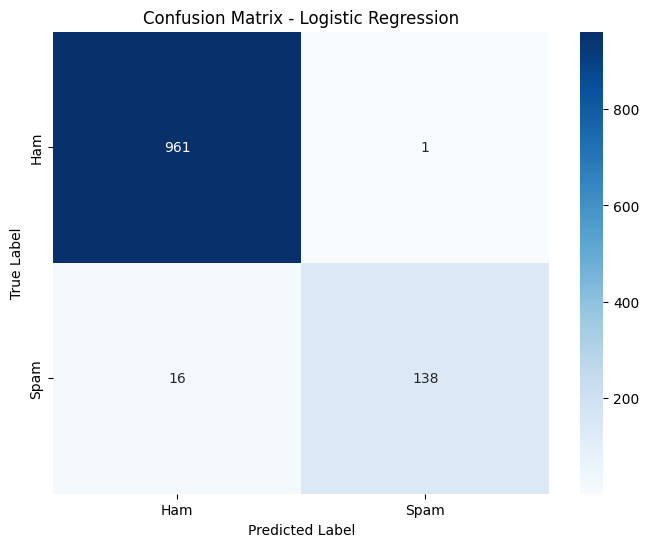

In [96]:
# Computing the confusion matrix for the best logistic regression model
conf_matrix_logreg = confusion_matrix(y_test_labels, y_pred_best_logreg)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


**classification report**

In [97]:
# Generating the classification report for the best logistic regression model
class_report_logreg = classification_report(y_test_labels, y_pred_best_logreg, target_names=['Ham', 'Spam'])

# Print the classification report
print("Classification Report we got :\n")
print(class_report_logreg)

Classification Report we got :

              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       962
        Spam       0.99      0.90      0.94       154

    accuracy                           0.98      1116
   macro avg       0.99      0.95      0.97      1116
weighted avg       0.98      0.98      0.98      1116



**Cross-Validation**


In [98]:
# Performing the cross-validation on the best logistic regression model
cv_scores_logreg = cross_val_score(best_lr_model, X, y, cv=10, scoring='accuracy')

# Printing cross-validation results
print(f"Cross-Validation Accuracy Scores: {cv_scores_logreg}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores_logreg):.2f}")
print(f"Standard Deviation of Cross-Validation Accuracy: {np.std(cv_scores_logreg):.2f}")

Cross-Validation Accuracy Scores: [0.99462366 0.98028674 0.98387097 0.98566308 0.98028674 0.98566308
 0.98384201 0.97845601 0.98743268 0.98922801]
Mean Cross-Validation Accuracy: 0.98
Standard Deviation of Cross-Validation Accuracy: 0.00


**ROC Curve and AUC Score**

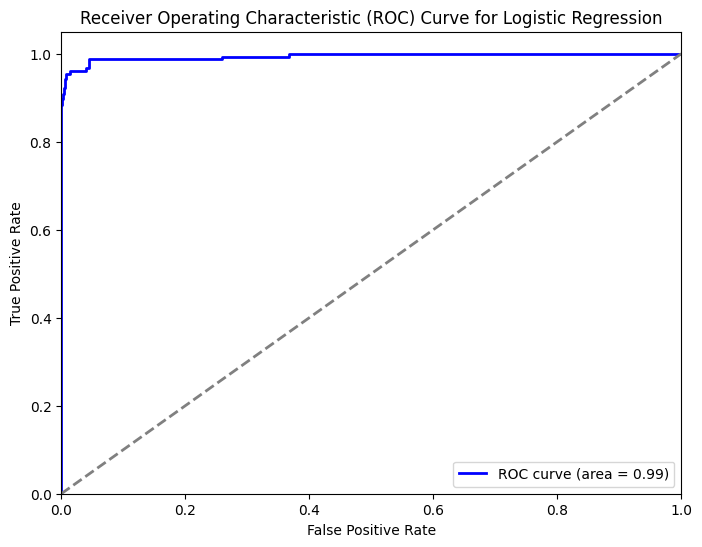

In [99]:
# Predict probabilities using the best logistic regression model
y_pred_proba_logreg = best_lr_model.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC for logistic regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test_labels, y_pred_proba_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Plot ROC curve for logistic regression
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()


**Save and Load Model**

In [100]:
# Saving the best logistic regression model to disk
joblib.dump(best_lr_model, 'best_logistic_regression_model.pkl')


['best_logistic_regression_model.pkl']

In [101]:
# Loading the best logistic regression model from disk
loaded_model = joblib.load('best_logistic_regression_model.pkl')

# Evaluating the loaded model on test data
y_pred_loaded_model = loaded_model.predict(X_test_tfidf)
accuracy_loaded_model = accuracy_score(y_test_labels, y_pred_loaded_model)

# Printing the accuracy of the loaded model
print(f"Loaded Model Accuracy we got is : {accuracy_loaded_model:.2f}")



Loaded Model Accuracy we got is : 0.98
